# 問4-4 スポット・レートの推定

In [1]:
import pandas as pd
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### 債券データを入力

In [2]:
bond_data = pd.DataFrame(data=[
    [6.625, datetime.date(2022, 2, 15), 100.00],
    [9.125, datetime.date(2022, 2, 15), 100.69],
    [7.875, datetime.date(2022, 8, 15), 100.75],
    [8.250, datetime.date(2022, 8, 15), 101.03],
    [8.250, datetime.date(2023, 2, 15), 101.22],
    [8.375, datetime.date(2023, 2, 15), 101.38],
    [8.000, datetime.date(2023, 8, 15), 100.81],
    [8.750, datetime.date(2023, 8, 15), 102.03],
    [6.875, datetime.date(2024, 2, 15),  98.16],
    [8.875, datetime.date(2024, 2, 15), 102.28],
    [6.875, datetime.date(2024, 8, 15),  97.41],
    [8.625, datetime.date(2024, 8, 15), 101.72],
    [7.750, datetime.date(2025, 2, 15),  99.16],
    [11.25, datetime.date(2025, 2, 15), 109.13],
    [8.500, datetime.date(2025, 8, 15), 101.41],
    [10.50, datetime.date(2025, 8, 15), 107.84],
    [7.875, datetime.date(2026, 2, 15),  99.41],
    [8.875, datetime.date(2026, 2, 15), 103.00],
    ],
    columns=['クーポン', '満期日', '価格'])

bond_data.head()

,クーポン,満期日,価格
0,6.625,2022-02-15,100.00
1,9.125,2022-02-15,100.69
2,7.875,2022-08-15,100.75
3,8.250,2022-08-15,101.03
4,8.250,2023-02-15,101.22


$t'_0 = \mbox{2021/11/05}$（現在）<br>
$t_0  = \mbox{2021/08/15}$（現在の直前にクーポンが支払われた時間）<br>
とする。

In [3]:
now = datetime.date(2021, 11, 5)
t0 = datetime.date(2021, 8, 15)

|クーポン|満期日|価格|
|:---:|:---:|:---:|
|$C_i$|$t_i$|$P_i$|

と言う$i$番目の債券について考える。

この債券の総価格$\tilde P_i$は、時刻$t_0$から現在$t'_0$までの経過利息を価格$P_i$に加えた

$$\tilde P_i = P_i + C_i(t'_0-t_0)$$

となる。これが現在$t'_0$における$i$番目の債券の購入価格となる。


In [4]:
bond_data['総価格'] = bond_data['価格'] + bond_data['クーポン']*(now - t0).days/365

In [5]:
bond_data.head()

,クーポン,満期日,価格,総価格
0,6.625,2022-02-15,100.00,101.488356
1,9.125,2022-02-15,100.69,102.740000
2,7.875,2022-08-15,100.75,102.519178
3,8.250,2022-08-15,101.03,102.883425
4,8.250,2023-02-15,101.22,103.073425


次に連続時間でのスポット・レートを定義する。

$$r(t) = a_0 + a_1t + a_2t^2 +a_3t^3 + a_4t^4$$

$$d(t) = e^{-r(t)t}$$

In [6]:
def r(t,a):
    return a[0] + a[1]*t + a[2]*t**2 + a[3]*t**3 + a[4]*t**4
def d(t,a):
    return torch.exp(-r(t,a)*t)

In [7]:
a = torch.tensor([0.01,0.01,0.01,0.01,0.01], requires_grad=True)
d(5, a)

tensor(1.0985e-17, grad_fn=<ExpBackward>)

今、$i$番目の債券の総価格は分かったので、次にその現在価値を、連続時間のスポット・レート$r(t)$を用いて求める。<br>
支払いのキャッシュフローは

|年|キャッシュフロー|現在価値|
|:---:|:---:|:---:|
|$t_0+\frac{1}{2}$|$\frac{1}{2}C_i$|$\frac{1}{2}C_id(t_0+\frac{1}{2}-t'_0)$|
|$t_0+1$|$\frac{1}{2}C_i$|$\frac{1}{2}C_id(t_0+1-t'_0)$|
|$t_0+\frac{3}{2}$|$\frac{1}{2}C_i$|$\frac{1}{2}C_id(t_0+\frac{3}{2}-t'_0)$|
|$\vdots$|$\vdots$|$\vdots$|
|$t_i$|$\frac{1}{2}C_i+100$|$(\frac{1}{2}C_i+100)d(t_i-t'_0)$|

となる。よって$i$番目の債券の現在価値$PV_i$は、それぞれの時刻におけるキャッシュフローの現在価値を合計するので、

$$
 PV_i = \sum_{t=t_0+\frac{1}{2}}^{t_i}\frac{1}{2}C_id(t-t'_0)+100d(t_i-t'_0)
$$

以上より、Lossの設計は
$$Loss({\boldsymbol a}) = \sum_i(\tilde P_i-PV_i)^2$$
となる。

In [8]:
def Loss(a):
    ret = 0
    for bond in bond_data.itertuples():
        i = bond.Index
        Ci = bond.クーポン
        ti = bond.満期日
        Pi = bond.総価格
        
        PV = 0
        for t in np.arange(t0+datetime.timedelta(184), ti+datetime.timedelta(1)).astype(object):
            if not ((t.month==2 or t.month==8) and t.day==15):
                continue
            PV += 1/2*Ci*d((t-t0).days/365, a)
        PV += 100*d((ti-t0).days/365, a)

        ret += (Pi-PV)**2
    return ret

適当な最適化手法を用いて$Loss({\boldsymbol a})$を最小にする${\boldsymbol a}$を求める。

In [305]:
a = torch.tensor([0.1]*5, requires_grad=True)
optimizer = optim.Adam([a])

roop = 0
minLoss = np.inf
print(roop, Loss(a).item(), a.data)
while roop<10000:
    roop += 1
    loss = Loss(a)
    loss.backward()
    optimizer.step()
    a.grad.data.zero_()
    if minLoss > Loss(a).item():
        minLoss=Loss(a)
        ans = a.data
        print(roop, Loss(a).item(), a.data)
        continue
    if roop%100==0:
        print(roop, Loss(a).item(), a.data)

, -9.2292e-04,  7.9943e-05])
9797 0.7904438376426697 tensor([ 3.9948e-02,  1.2396e-02,  1.5071e-03, -9.2305e-04,  7.9961e-05])
9798 0.7903159856796265 tensor([ 3.9947e-02,  1.2397e-02,  1.5072e-03, -9.2318e-04,  7.9980e-05])
9799 0.7902154922485352 tensor([ 3.9946e-02,  1.2398e-02,  1.5073e-03, -9.2331e-04,  7.9999e-05])
9800 0.7900943756103516 tensor([ 3.9945e-02,  1.2398e-02,  1.5074e-03, -9.2344e-04,  8.0017e-05])
9801 0.7900058031082153 tensor([ 3.9944e-02,  1.2399e-02,  1.5074e-03, -9.2357e-04,  8.0036e-05])
9802 0.7898628115653992 tensor([ 3.9943e-02,  1.2400e-02,  1.5075e-03, -9.2369e-04,  8.0055e-05])
9803 0.7897583842277527 tensor([ 3.9942e-02,  1.2401e-02,  1.5076e-03, -9.2382e-04,  8.0073e-05])
9804 0.7896391153335571 tensor([ 3.9941e-02,  1.2402e-02,  1.5077e-03, -9.2395e-04,  8.0091e-05])
9805 0.7895389199256897 tensor([ 3.9940e-02,  1.2402e-02,  1.5078e-03, -9.2408e-04,  8.0110e-05])
9806 0.7894288897514343 tensor([ 3.9939e-02,  1.2403e-02,  1.5079e-03, -9.2421e-04,  8.01

In [306]:
print(ans.data)
Loss(ans.data).item()

tensor([ 3.9725e-02,  1.2560e-02,  1.5246e-03, -9.4998e-04,  8.3856e-05])


0.767188549041748

Text(0,0.5,'r(t)')

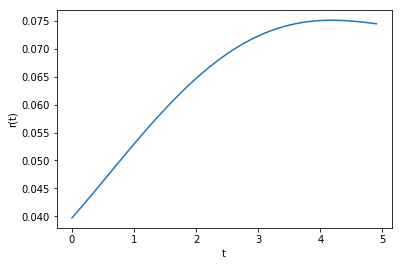

In [14]:
x = np.arange(0,5, 0.1)
y = r(t=x, a=ans)
plt.plot(x,y)
plt.xlabel('t')
plt.ylabel('r(t)')